In [1]:
import mujoco
import mujoco.viewer
import time
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
import imageio
import os
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


[ 3.0840758  -0.          3.73999125]


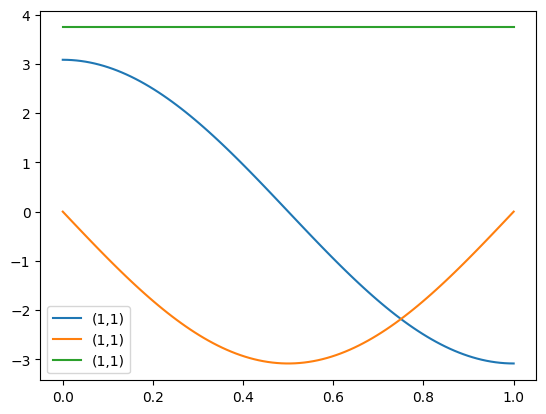

In [2]:
def ang_vel(t,T,Dphi,Dpsi,I_trans,I_long):
    I_ratio = I_trans/I_long
    if np.abs(Dpsi/Dphi) > (np.abs(I_ratio)-1):
        print('The system you provided is in wobbling mode.')
    #print(1/(I_ratio-1)*Dpsi/Dphi)
    theta = np.arcsin(1/(I_ratio-1)*Dpsi/Dphi)
    omega = np.zeros((len(t),3))
    for i in range(len(t)):
        h = Dphi*I_trans/T
        omega[i] = h*np.array([np.cos(theta)*np.cos(Dpsi*t[i]/T)/I_trans,
                             -np.cos(theta)*np.sin(Dpsi*t[i]/T)/I_trans,
                             np.sin(theta)/I_long])
    return omega

def T_from_v0(v0,g=9.81,z0=0):
    return (v0+np.sqrt(v0**2+2*g*z0))/g

T = 2
m = 0.1
a = 1
c = 0.4
I_trans = 2*m*a**2
I_long = 2*m*c**2
Dphi = 1
Dpsi = 1

t = np.linspace(0,1,100)

h = I_trans*Dphi/T
omega = ang_vel(t,T,2*np.pi*Dphi,2*np.pi*Dpsi,I_trans,I_long)
plt.plot(t,omega,'-',label='('+str(Dphi)+','+str(Dpsi)+')')
print(omega[0])
plt.legend()

In [3]:
import mujoco, numpy as np, time

model = mujoco.MjModel.from_xml_path("variable_box.xml")
data  = mujoco.MjData(model)

# parameters
M       = 1.0
R_EDGE  = 0.02
EPS     = 2e-2
I_FLOOR = 1e-6

# ids/addresses
center_bid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "center")
jx = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "jx+")
jy = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "jx+y+")
jz = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "jx+y+z+")
jx_q, jy_q, jz_q = model.jnt_qposadr[jx], model.jnt_qposadr[jy], model.jnt_qposadr[jz]

free_jid = next(i for i in range(model.njnt) if model.jnt_type[i] == mujoco.mjtJoint.mjJNT_FREE)
free_q = model.jnt_qposadr[free_jid]   # root position starts at qpos[free_q : free_q+3]

edge_names = [
    "edge_x_pp","edge_x_pn","edge_x_np","edge_x_nn",
    "edge_y_pp","edge_y_pn","edge_y_np","edge_y_nn",
    "edge_z_pp","edge_z_pn","edge_z_np","edge_z_nn",
]
edges = {nm: mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, nm) for nm in edge_names}

def place_above_floor(uz):
    data.qpos[free_q + 2] = float(uz) + R_EDGE + 1e-3  # z = uz + radius + margin

def set_extents(ux, uy, uz):
    data.qpos[jx_q], data.qpos[jy_q], data.qpos[jz_q] = ux, uy, uz
    place_above_floor(uz)

def update_edges_and_inertia():
    ux = max(float(data.qpos[jx_q]), EPS)
    uy = max(float(data.qpos[jy_q]), EPS)
    uz = max(float(data.qpos[jz_q]), EPS)

    # edges
    for name, (y,z) in {"edge_x_pp":(+uy,+uz),"edge_x_pn":(+uy,-uz),
                        "edge_x_np":(-uy,+uz),"edge_x_nn":(-uy,-uz)}.items():
        gid = edges[name]; model.geom_pos[gid,:] = [0.0,y,z]; model.geom_size[gid,:] = [R_EDGE,ux,0.0]
    for name, (x,z) in {"edge_y_pp":(+ux,+uz),"edge_y_pn":(+ux,-uz),
                        "edge_y_np":(-ux,+uz),"edge_y_nn":(-ux,-uz)}.items():
        gid = edges[name]; model.geom_pos[gid,:] = [x,0.0,z]; model.geom_size[gid,:] = [R_EDGE,uy,0.0]
    for name, (x,y) in {"edge_z_pp":(+ux,+uy),"edge_z_pn":(+ux,-uy),
                        "edge_z_np":(-ux,+uy),"edge_z_nn":(-ux,-uy)}.items():
        gid = edges[name]; model.geom_pos[gid,:] = [x,y,0.0]; model.geom_size[gid,:] = [R_EDGE,uz,0.0]

    # inertia of solid box (2ux × 2uy × 2uz)
    Ixx = max((M/3.0)*(uy*uy + uz*uz), I_FLOOR)
    Iyy = max((M/3.0)*(ux*ux + uz*uz), I_FLOOR)
    Izz = max((M/3.0)*(ux*ux + uy*uy), I_FLOOR)
    model.body_mass[center_bid]       = M
    model.body_inertia[center_bid,:]  = [Ixx, Iyy, Izz]

# ---- init before viewer ----
model.opt.gravity = [0,0,-9.81]
set_extents(0.30, 0.30, 0.50)    # half-extents
update_edges_and_inertia()
mujoco.mj_forward(model, data)

# ---- run ----
with mujoco.viewer.launch_passive(model, data) as viewer:
    while viewer.is_running():
        update_edges_and_inertia()     # keep edges + inertia synced
        mujoco.mj_forward(model, data) # apply changes
        mujoco.mj_step(model, data)
        viewer.sync()
        time.sleep(model.opt.timestep)


/home/yugiero/tma_env/lib/python3.10/site-packages/glfw/__init__.py:917: GLFWError: (65548) b'Wayland: The platform does not provide the window position'
  warnings.warn(message, GLFWError)
